In [9]:
%matplotlib inline

# from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Fix the path construction - use forward slashes or raw strings
import os

In [10]:

# Method 1: Use forward slashes (recommended)
path = os.path.abspath(os.path.join("..", "04_S&P500_quant_analysis", "01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 2: Use raw string
# path = os.path.abspath(os.path.join("..", r"04_S&P500_quant_analysis\01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 3: Use pathlib (modern approach)
# from pathlib import Path
# path = Path("..") / "04_S&P500_quant_analysis" / "01_data" / "S&P500_D_1789-05-01_2025-09-17.csv"

print(f"Path exists: {os.path.exists(path)}")

# Read the CSV file
df = pd.read_csv(path)

# lower case column names for easier access
df.columns = [col.lower() for col in df.columns]

# Set the 'date' column as the index and convert it to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# filter years from 1960
df = df[df.index.year >= 1960]

# Show the first few rows of the dataframe
df.head()

Path exists: True


,open,high,low,close,volume
date,,,,,
1960-01-04,59.91,59.91,59.91,59.91,2216667.0
1960-01-05,60.39,60.39,60.39,60.39,2061111.0
1960-01-06,60.13,60.13,60.13,60.13,2072222.0
1960-01-07,59.69,59.69,59.69,59.69,1838889.0
1960-01-08,59.50,59.50,59.50,59.50,1827778.0


In [11]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [12]:
sns.set_style('whitegrid')
np.random.seed(42)

In [13]:
# results_path = Path('results', 'univariate_time_series')
# if not results_path.exists():
#     results_path.mkdir(parents=True)

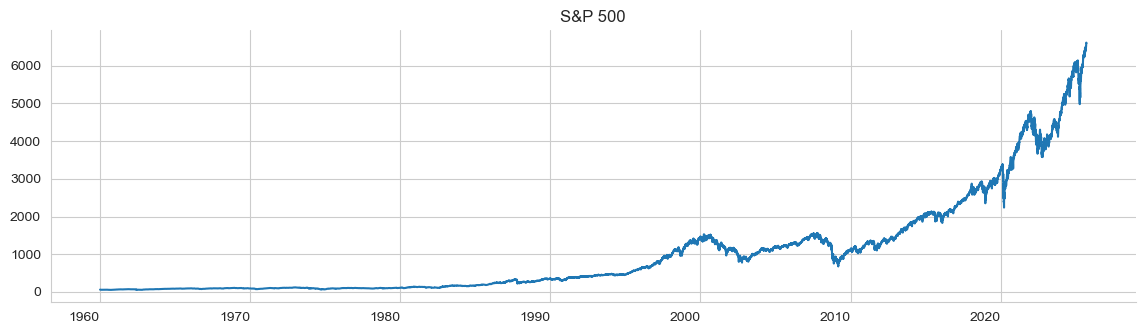

In [14]:
sp500 = df.close.copy()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()